In [1]:
import html

import torch
from datasets import load_dataset
from torch import nn
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")

from modules.utils import create_pad_mask, create_subsequent_mask, BPETokenizer

In [2]:
vi_en_dataset = load_dataset(
    "mt_eng_vietnamese", "iwslt2015-vi-en", cache_dir="datasets"
)


def unescape(batch):
    batch["vi"] = html.unescape(batch["translation"]["vi"])
    batch["en"] = html.unescape(batch["translation"]["en"])
    return batch


del vi_en_dataset["validation"]
vi_en_dataset = vi_en_dataset.map(unescape, remove_columns="translation")
vi_en_dataset.save_to_disk("datasets/processed")

Found cached dataset mt_eng_vietnamese (/media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/mt_eng_vietnamese/iwslt2015-vi-en/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/mt_eng_vietnamese/iwslt2015-vi-en/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71/cache-fc7fd65423ac5fc0.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/mt_eng_vietnamese/iwslt2015-vi-en/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71/cache-42424f4ef5424984.arrow


Saving the dataset (0/1 shards):   0%|          | 0/133318 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1269 [00:00<?, ? examples/s]

In [2]:
from datasets import load_from_disk

vi_en_dataset = load_from_disk("datasets/processed")

In [3]:
import re


def clean(batch):
    en = batch["en"].lower()
    vi = batch["vi"].lower()

    en = re.sub(r"\s+", " ", en).strip()
#    en = re.sub(r"([0-9,.]{2,})(?![a-z-])", "", en)
#    en = re.sub(r"[-.]{2,}[0-9.]*", "", en)
    en = " ".join(list(filter(lambda x: len(x), en.split())))
    batch["en"] = en

    vi = re.sub(r"\s+", " ", vi).strip()
#    vi = re.sub(r"([0-9,.]{2,})(?![a-z-])", "", vi)
#    vi = re.sub(r"[-.]{2,}[0-9.]*", "", vi)
    vi = " ".join(list(filter(lambda x: len(x), vi.split())))
    batch["vi"] = vi
    return batch


vi_en_dataset = vi_en_dataset.map(clean)

Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed/train/cache-196c82b5e6a7bca1.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed/test/cache-63dd10933077689b.arrow


In [4]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizer.pth"))

In [5]:
from torch.nn.functional import pad
from torch.utils.data import Dataset


class TextDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __getitem__(self, index):
        return (
            self.src[index],
            len(self.src[index]),
            self.tgt[index],
            len(self.tgt[index]),
        )

    def __len__(self):
        return len(self.src)

    @classmethod
    def pad(cls, inputs, tgt=False):
        def pad_data(x, length):
            x_padded = pad(x, (0, length - x.shape[0]), mode="constant", value=tokenizer._st2i[tokenizer.pad])
            return x_padded

        max_len = max((len(x) for x in inputs)) + tgt
        padded = torch.stack([pad_data(torch.LongTensor(x), max_len) for x in inputs])

        return padded

    @classmethod
    def collate_fn(cls, batch):
        src = []
        src_lens = []
        tgt = []
        tgt_lens = []
        for s, sl, t, tl in batch:
            src.append(s)
            src_lens.append(sl)
            tgt.append(t)
            tgt_lens.append(tl)
        return (
            cls.pad(src),
            torch.LongTensor(src_lens),
            cls.pad(tgt, tgt=True),
            torch.LongTensor(tgt_lens),
        )

In [6]:
def token2idx(batch):
    batch["ids_vi"] = (
        [tokenizer._st2i[tokenizer.sos]] + tokenizer(batch["vi"]) + [tokenizer._st2i[tokenizer.eos]]
    )
    batch["ids_en"] = tokenizer(batch["en"])

    return batch

In [7]:
vi_en_ids = vi_en_dataset.map(
    token2idx, remove_columns=vi_en_dataset.column_names["train"]
)

Map:   0%|          | 0/133318 [00:00<?, ? examples/s]

Map:   0%|          | 0/1269 [00:00<?, ? examples/s]

In [8]:
vi_en_ids.save_to_disk("datasets/processed_ids")

Saving the dataset (0/1 shards):   0%|          | 0/133318 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1269 [00:00<?, ? examples/s]

In [15]:
max_length = 256

In [16]:
vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

Filter:   0%|          | 0/133318 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1269 [00:00<?, ? examples/s]

In [17]:
vi_en_ids

DatasetDict({
    train: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 133137
    })
    test: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1268
    })
})

In [19]:
print(tokenizer.decode(vi_en_ids["train"]["ids_en"][56]))

['you', ' can', ' mimic', ' what', ' you', ' can', ' see', ' .']


In [20]:
train, val = vi_en_ids["train"].train_test_split(test_size=0.01).values()
vi_en_ids.update({"train": train, "val": val})

In [28]:
vi_en_ids.save_to_disk("datasets/processed_ids_splits")

Saving the dataset (0/1 shards):   0%|          | 0/131805 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1268 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1332 [00:00<?, ? examples/s]

In [22]:
from torch.utils.data import DataLoader

batch_size = 16
train_dl = DataLoader(
    TextDataset(vi_en_ids["train"]["ids_en"], vi_en_ids["train"]["ids_vi"]),
    batch_size= 2* batch_size,
    pin_memory=True,
    shuffle=True,
    collate_fn=TextDataset.collate_fn,
)
val_dl = DataLoader(
    TextDataset(vi_en_ids["val"]["ids_en"], vi_en_ids["val"]["ids_vi"]),
    batch_size=2 * batch_size,
    pin_memory=True,
    shuffle=False,
    collate_fn=TextDataset.collate_fn,
)
test_dl = DataLoader(
    TextDataset(vi_en_ids["test"]["ids_en"], vi_en_ids["test"]["ids_vi"]),
    batch_size=2 * batch_size,
    pin_memory=True,
    shuffle=False,
    collate_fn=TextDataset.collate_fn,
)

In [36]:
import numpy as np
from collections import Counter

def bleu_score(candidates, references):
    bleu = 0

    def one(candidate, reference):
        can = Counter(candidate)
        ref = Counter(reference)
        overlap = 0
        for c in can:
            overlap += min(can.get(c, 0), ref.get(c, 0))

        return (
            min(1, np.exp(1 - len(reference) / len(candidate)))
            * overlap
            / sum(can.values())
        )

    for candidate, reference in zip(candidates, references):
        if not isinstance(candidate, list) or not isinstance(reference, list):
            candidate, reference = candidate.tolist(), reference.tolist()
            if tokenizer._st2i[tokenizer.pad] in candidate:
                candidate = candidate[:candidate.index(tokenizer._st2i[tokenizer.pad])]
            if tokenizer._st2i[tokenizer.pad] in reference:
                reference = reference[:reference.index(tokenizer._st2i[tokenizer.pad])]
        bleu += one(candidate, reference)

    return bleu / len(candidates)

In [37]:
bleu_score([[1,2,3,44,0],[423,223,33,21,13]],[[32,2,1,4,6,3],[33,12,3,12,3,0]])

0.3274923012311928

In [50]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from models.transformer import Transformer
from modules.utils import count_params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocab_size = len(tokenizer)
n_heads = 4
n_blocks = 4
d_model = 128
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.1

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
count_params(model)
optimizer = Adam(model.parameters(), lr=0.0002, betas=(0.98, 0.99))
scheduler = ExponentialLR(optimizer, 0.99**0.125)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1,ignore_index=tokenizer._st2i[tokenizer.pad])

Total: 5,973,248 parameters.
Trainable: 5,973,248 parameters.


In [29]:
import math

math.exp(-4.5)

0.011108996538242306

In [30]:
lre = torch.linspace(-6,-0.6,1000)

In [ ]:
losses = []
lrs = []
i = 0
while i < len(lre):
    for src, src_lens, tgt, tgt_lens in val_dl:
        src, src_lens, tgt, tgt_lens = (
            src.to(device),
            src_lens.to(device),
            tgt.to(device),
            tgt_lens.to(device),
        )

        src_mask = create_pad_mask(src_lens)
        tgt_0 = tgt[:, :-1]
        tgt_0_mask = create_subsequent_mask(tgt_lens, pad_mask=create_pad_mask(tgt_lens))
        tgt_1 = tgt[:, 1:].contiguous().view(-1)

        optimizer.param_groups[0]['lr'] = math.exp(lre[i])
        logits = model(src, src_mask, tgt_0, tgt_0_mask)
        loss = loss_fn(logits.view(-1, vocab_size), tgt_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(optimizer.param_groups[0]['lr'])
        
        losses.append(loss.item())
        lrs.append(lre[i])
        i += 1
        if i == len(lre):
            break

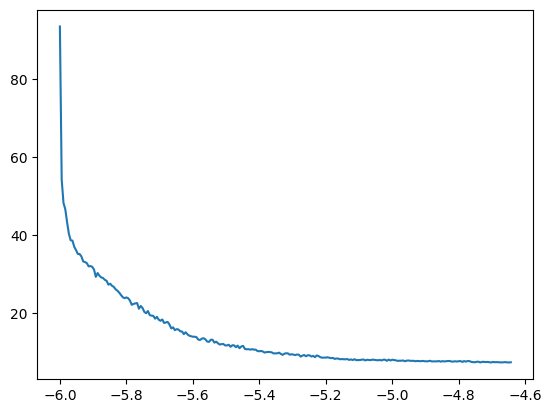

In [32]:
import matplotlib.pyplot as plt

plt.plot(lrs,losses)

In [63]:
import os

os.makedirs("checkpoints", exist_ok=True)


def train_and_eval(
    model,
    optimizer,
    loss_fn,
    scheduler,
    epochs,
    train_dl,
    val_dl,
    early_stopping=10,
    model_name="sample_model",
):
    p_bar = tqdm(total=len(train_dl))

    best_val_loss = 25042001
    patience = 0

    for epoch in range(epochs):
        train_loss = 0
        train_bleu = 0
        val_loss = 0
        val_bleu = 0

        model.train()
        for src, src_lens, tgt, tgt_lens in train_dl:
            src, src_lens, tgt, tgt_lens = (
                src.to(device),
                src_lens.to(device),
                tgt.to(device),
                tgt_lens.to(device),
            )

            src_mask = create_pad_mask(src_lens)
            tgt_0 = tgt[:, :-1]
            tgt_0_mask = create_subsequent_mask(tgt_lens, pad_mask=create_pad_mask(tgt_lens))
            tgt_1 = tgt[:, 1:].contiguous().view(-1)

            logits = model(src, src_mask, tgt_0, tgt_0_mask)
            loss = loss_fn(logits.view(-1, vocab_size), tgt_1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bleu += bleu_score(logits.argmax(-1), tgt[:, 1:])

            p_bar.update(1)
        scheduler.step()

        model.eval()
        print(''.join(tokenizer.decode(decode(model,tokenizer,'a single female will lay about up to eggs at a time , up to about in her lifetime .')[0].tolist())))
        with torch.inference_mode():
            for src, src_lens, tgt, tgt_lens in val_dl:
                src, src_lens, tgt, tgt_lens = (
                    src.to(device),
                    src_lens.to(device),
                    tgt.to(device),
                    tgt_lens.to(device),
                )

                src_mask = create_pad_mask(src_lens)
                tgt_0 = tgt[:, :-1]
                tgt_0_mask = create_subsequent_mask(tgt_lens, pad_mask=create_pad_mask(tgt_lens))
                tgt_1 = tgt[:, 1:].contiguous().view(-1)

                logits = model(src, src_mask, tgt_0, tgt_0_mask)
                loss = loss_fn(logits.view(-1, vocab_size), tgt_1)

                val_loss += loss.item()
                val_bleu += bleu_score(logits.argmax(-1), tgt[:, 1:])

        train_loss /= len(train_dl)
        val_loss /= len(val_dl)
        train_bleu = train_bleu / len(train_dl)
        val_bleu = val_bleu / len(val_dl)

        if val_loss > best_val_loss:
            patience += 1
        else:
            torch.save(
                model.state_dict(),
                f"checkpoints/{model_name}.pth",
            )
            patience = 0
            best_val_loss = val_loss

        print(
            f"Epoch {epoch+1}:\n Train loss: {train_loss:.6f} - Train bleu: {train_bleu:.6f}\n Val loss: {val_loss:.6f} - Val bleu: {val_bleu:.6f}"
        )

        if patience >= early_stopping:
            print(
                f"Stopped since val loss has not improved in the last {early_stopping} epochs..."
            )
            break

        p_bar.reset()

In [67]:
epochs = 1000
model_name = "translation"
train_and_eval(
    model,
    optimizer,
    loss_fn,
    scheduler,
    epochs,
    val_dl,
    val_dl,
    model_name=model_name,
    early_stopping=50
)

  0%|          | 0/42 [00:00<?, ?it/s]

<sos>như chiếc ký triệu nơi mà chúng ta biết rằng bạn trang gì đối với nhau , và bạn đi lên chụp sau một hành động về một hành động
Epoch 1:
 Train loss: 3.820629 - Train bleu: 0.200767
 Val loss: 2.931866 - Val bleu: 0.244299
<sos> bàn functionality hình thì chúng ta là một hành động tài nguyên thể hiện ra cải cách gì phát minh là một hành động về một hành động tài nguyên
Epoch 2:
 Train loss: 3.793968 - Train bleu: 0.202199
 Val loss: 2.927662 - Val bleu: 0.243860
<sos> mỳ .<eos>
Epoch 3:
 Train loss: 3.773126 - Train bleu: 0.204438
 Val loss: 2.904943 - Val bleu: 0.246178
<sos> mỳ về con người chủ chủ chủ chủ chủ chủ chủ chủ chủ chủ chủ nghĩa chia sẻ và thời gian tài mau chủ nghĩa là bạn về con karl
Epoch 4:
 Train loss: 3.763139 - Train bleu: 0.204368
 Val loss: 2.887444 - Val bleu: 0.246854
<sos>như karl karl karl karl karl karl karl karl karl karl karl karl karl karl karl karl karl sức khoẻ về nơi mà bao giờ là một nơi màs.
Epoch 5:
 Train loss: 3.754018 - Train bleu: 0.203864
 V

KeyboardInterrupt: 

In [26]:
model.load_state_dict(torch.load('checkpoints/translation-128-4-4.pth'))

<All keys matched successfully>

In [65]:
def decode(model,tokenizer, src, max_token=30):
    src_ids = torch.tensor([tokenizer(src)]).to(device)
    src_lens = torch.tensor([src_ids.shape[1]], dtype=torch.int64)
    src_mask = create_pad_mask(src_lens).to(device)

    tgt_ids = torch.tensor([[tokenizer._st2i[tokenizer.sos]]]).to(device)
    tgt_lens = torch.tensor([[1]], dtype=torch.int64)
    tgt_mask = create_subsequent_mask(
        tgt_lens, pad_mask=create_pad_mask(tgt_lens)
    ).to(device)

    model.eval()
    with torch.inference_mode():
        encoder_outputs = model.encode(src_ids, src_mask)
        while tgt_ids[0][-1] != tokenizer._st2i[tokenizer.eos] and max_token > 0:
            next = model.generate(tgt_ids, tgt_mask, encoder_outputs, src_mask)
            tgt_ids = torch.cat((tgt_ids, next[:, -1].argmax(-1, keepdim=True)), dim=-1)
            tgt_lens += 1
            tgt_mask = create_subsequent_mask(
                tgt_lens, pad_mask=create_pad_mask(tgt_lens)
            ).to(device)
            max_token -= 1
    return tgt_ids

In [66]:
tokenizer.decode(decode(model,tokenizer,'a single female will lay about up to eggs at a time , up to about in her lifetime .')[0].tolist())

['<sos>',
 ' bàn',
 ' gì',
 ' như',
 ' một',
 ' hành',
 ' động',
 ' là',
 ' một',
 ' hành',
 ' động',
 ' về',
 ' con',
 ' người',
 ' và',
 ' điều',
 ' gì',
 ' về',
 ' một',
 ' hành',
 ' động',
 ' về',
 ' nơi',
 ' nơi',
 ' mà',
 ' nhiều',
 ' về',
 ' con',
 ' người',
 ' gì',
 ' sau']